## Importation des données

In [19]:
# récupération des librairies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import io

from google.colab import files

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, mean_squared_error, recall_score, f1_score, precision_score
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression

from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from imblearn.over_sampling import RandomOverSampler

# from imblearn.metrics import classification_report_imbalanced
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [3]:
# chargement des données en local
uploaded = files.upload()

Saving weatherAUS_preprocessed.csv to weatherAUS_preprocessed.csv


In [4]:
# récuperation et aperçu du jeu de données après prétraitement, après l'étape de classification des villes en fonction 
# du climat et après sélection des variables les plus pertinentes selon la méthode SelectKBest()
df = pd.read_csv('weatherAUS_preprocessed.csv', index_col=0)
df.head()

,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,Temp_Delta_MinMax,Humidity_Delta,clim_chaud_humide,clim_méditerranéen,clim_sec,clim_tempéré_froid,RainTomorrow
0,0.6,4.94000,44.0,22.0,1007.7,7.40000,21.8,9.5,-49.0,1,0,0,0,0
1,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,17.7,-19.0,1,0,0,0,0
2,0.0,7.96000,46.0,30.0,1007.6,2.00000,23.2,12.8,-8.0,1,0,0,0,0
3,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,18.8,-29.0,1,0,0,0,0
4,1.0,0.90000,41.0,33.0,1010.8,8.00000,29.7,14.8,-49.0,1,0,0,0,0


## Régression Logistique


In [5]:
# séparation des données en une matrice de données et en un vecteur cible
data = df.drop('RainTomorrow', axis=1)
target = df['RainTomorrow']

In [8]:
# division des données en un ensemble d'entraînement et un ensemble de test correspondant respectivement à 80% et 20% de la quantité totale des données disponibles
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=123)

In [9]:
# undersampling des données
rUs = RandomUnderSampler()
X_train_ru, y_train_ru = rUs.fit_resample(X_train, y_train)
print("Cardinalité des classes de la variable cible sous-échantillonnée:", dict(pd.Series(y_train_ru).value_counts()))

Cardinalité des classes de la variable cible sous-échantillonnée: {0: 25005, 1: 25005}


In [10]:
# standardisation des données
scaler = StandardScaler()
# scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# définition du modèle
clf_lr = LogisticRegression()

# param_grid_lr = {'solver':['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'], 
#                  'C':np.linspace(0.1,1,10)}

param_grid_lr = {'solver':['liblinear'], 
                 'C':np.linspace(0.1,1,10)}

gcv_lr = GridSearchCV(clf_lr, param_grid_lr, cv=3)

In [20]:
# entraînement
gcv_lr.fit(X_train_scaled, y_train)

# prédiction
y_pred = gcv_lr.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres :', gcv_lr.best_params_, "\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test,y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_lr.score(X_train_scaled,y_train)))
print('Test Data Score: {}'.format(gcv_lr.score(X_test_scaled,y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print('\n', classification_report(y_test, y_pred))


Meilleurs paramètres : {'C': 0.5, 'solver': 'liblinear'} 

Accuracy Score: 0.8439519852262235 

Train Data Score: 0.8398725017535448
Test Data Score: 0.8439519852262235

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            20742  1220
1             3174  3022

               precision    recall  f1-score   support

           0       0.87      0.94      0.90     21962
           1       0.71      0.49      0.58      6196

    accuracy                           0.84     28158
   macro avg       0.79      0.72      0.74     28158
weighted avg       0.83      0.84      0.83     28158



## Interprétabilité du modèle de régression logistique

(-0.8, 0.8)

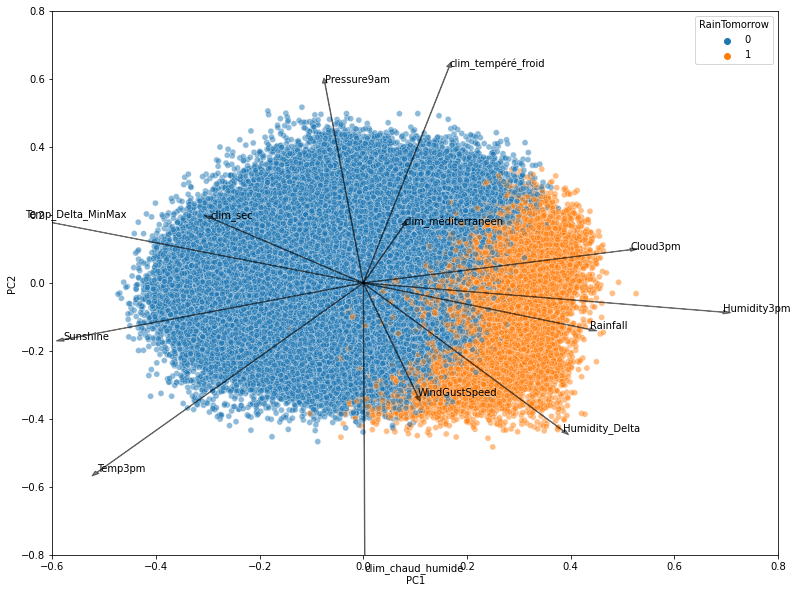

In [21]:
# Utilisation de l'ACP pour analyser les résultats de notre modèle
n = X_train.shape[1]

pca = PCA(n_components=2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_new = pca.fit_transform(X_train_scaled)

coeff = pca.components_.transpose()

xs = X_new[:, 0]
ys = X_new[:, 1]
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())


principalDf = pd.DataFrame({'PC1': xs*scalex, 'PC2': ys * scaley})

y_train_pred = gcv_lr.predict(X_train_scaled)
finalDF = pd.concat([principalDf, pd.Series(
    y_train_pred, name='RainTomorrow')], axis=1)


plt.figure(figsize=(13, 10))

sns.scatterplot(x='PC1', y='PC2', hue='RainTomorrow', data=finalDF, alpha=0.5)

for i in range(n):
    plt.arrow(0, 0, coeff[i, 0]*1.5, coeff[i, 1]*1.5,
              color='k', alpha=0.5, head_width=0.01, )
    plt.text(coeff[i, 0]*1.5, coeff[i, 1] * 1.5, X_train.columns[i], color='k')

plt.xlim(-0.6, 0.8)
plt.ylim(-0.8, 0.8)

Ce biplot nous permet de visualiser les classes de précipitations créées par notre modèle en fonction des variables explicatives. On observe que lorsqu'il pleut le jour suivant, en général le temps est nuageux et l'humidité est importante à 15h. 
Mais lorsqu'il ne pleut pas le lendemain, nous avons eu le jour d'avant un ensoleillement important et un climat sec.

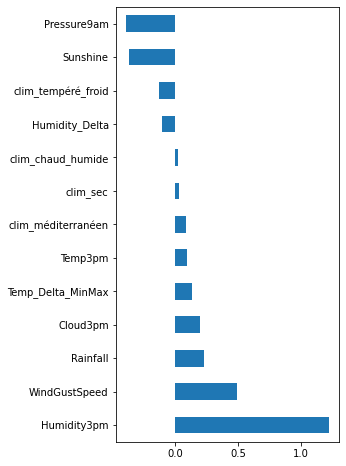

In [22]:
lr = LogisticRegression(C= 0.5, solver= 'liblinear')
lr.fit(X_train_scaled, y_train)

pd.Series(lr.coef_[0], X_train.columns).sort_values(ascending=False).plot(kind='barh', figsize=(4,8));

Les coefficients du modèle de régression logistique permettent d'avoir un aperçu des relations faites par le modèle entre chaque variable explicative et la variable cible. 
Dans notre cas, la variable Humidity3pm est élévée cela signifie que plus l'humidité à 15h est importante et plus la probabilité qu'il pleuve le lendemain est importante.